------------------------------------------------------------------------------
<center>
<h1>Análisis Supervisado<h1>
<h2>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones<h2>
<h3>Edición 2021<h3>
</center>



### Integrantes


* Devesa, María Roberta
* Feldfeber, Ivana
* Finzi, Nadia
* Kinigsberg, Ezequiel
* Villafañe, Roxana Noelia

**Ingreso las librerias**

In [ ]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
# from fastai.tabular.all import *

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import graphviz

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Ingreso el dataset**

Usamos pandas para leer el dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/data-datum/04.aprendizaje-supervisado/main/travel_insurance_prediction_train.csv", )
df = df.drop(['Customer', 'GraduateOrNot'], axis=1)

* Eliminamos la variable Customer ya que funciona como ID, no aporta nueva informacion.
* Eliminamos también la variable GraduateOrNot porque no mostro ser relevante para clasificar la variable de target: TravelInsurance. Despues de analizar las variables de mayor importancia de un modelo de RF se observo que GraduateOrNot no es significativa. 

In [ ]:
#previsualizo el dataset
df

,Age,Employment Type,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,33,Private Sector/Self Employed,550000,6,0,No,No,1
1,28,Private Sector/Self Employed,800000,7,0,Yes,No,0
2,31,Private Sector/Self Employed,1250000,4,0,No,No,0
3,31,Government Sector,300000,7,0,No,No,0
4,28,Private Sector/Self Employed,1250000,3,0,No,No,0
...,...,...,...,...,...,...,...,...
1485,31,Government Sector,300000,5,0,No,No,0
1486,31,Private Sector/Self Employed,950000,3,0,Yes,No,0
1487,28,Private Sector/Self Employed,1250000,5,0,No,No,0
1488,31,Government Sector,1300000,5,0,No,No,0


**Vemos a que categoria pertenecen las clases**

In [ ]:
# Variable target
df.TravelInsurance.value_counts()/len(df)

0    0.642953
1    0.357047
Name: TravelInsurance, dtype: float64

In [ ]:
print(f'Cardinalidad de variable Age {df.Age.nunique()}')

11

In [ ]:
## Nuevas cols
# no se usa de momento
df['Income_Family'] = df.AnnualIncome / df.FamilyMembers

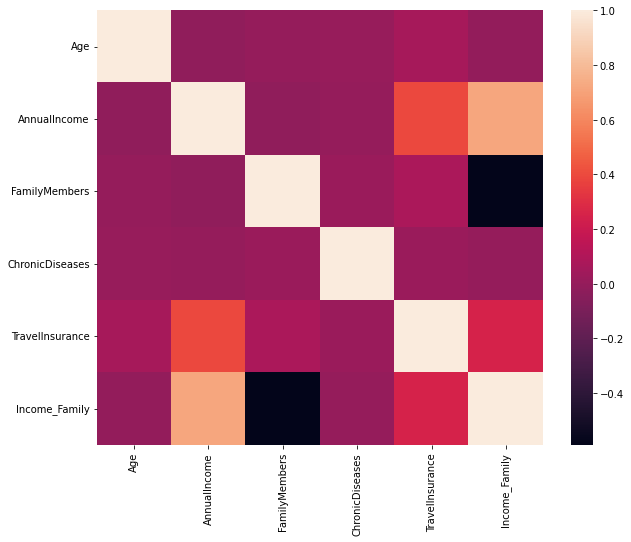

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr())

Aplicamos **OneHotEncoder** a las variables categoricas del dataset

In [ ]:
cont_names = ['AnnualIncome']
cat_names = ['Age', 'Employment Type', 'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad']

In [ ]:
oh = OneHotEncoder(drop=None, sparse=False)
df_cat = oh.fit_transform(df[cat_names])

In [ ]:
# oe = OrdinalEncoder(dtype='int', )
# oe.fit(df[cat_names])

In [ ]:
df_cat = pd.DataFrame(data=df_cat, columns=oh.get_feature_names(cat_names))
df_proc = pd.concat([df_cat, df[cont_names], df[['TravelInsurance']]], axis=1)

Despues de aplicar OneHotEncoder sobre las variables categoricas concatenamos los datasets resultantes para trabajar con un inco dataset.

In [ ]:
df_proc

,Age_25,Age_26,Age_27,Age_28,Age_29,Age_30,Age_31,Age_32,Age_33,Age_34,Age_35,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,FamilyMembers_2,FamilyMembers_3,FamilyMembers_4,FamilyMembers_5,FamilyMembers_6,FamilyMembers_7,FamilyMembers_8,FamilyMembers_9,ChronicDiseases_0,ChronicDiseases_1,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes,AnnualIncome,TravelInsurance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,550000,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,800000,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1250000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,300000,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,300000,0
1486,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,950000,0
1487,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1250000,0
1488,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1300000,0


Analizamos la variable continua AnualIncome

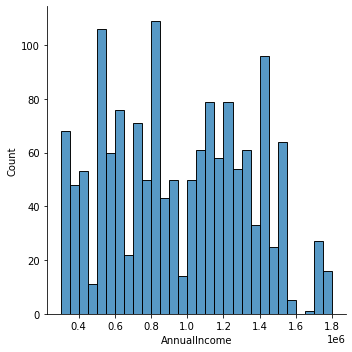

In [ ]:
# Distribución salario
sns.displot(data=df_proc.AnnualIncome, bins=30)

In [ ]:
(df_proc.AnnualIncome).describe()

count    1.490000e+03
mean     9.278188e+05
std      3.811715e+05
min      3.000000e+05
25%      6.000000e+05
50%      9.000000e+05
75%      1.250000e+06
max      1.800000e+06
Name: AnnualIncome, dtype: float64

Para comvertirla en categorica (numerica) separamos por los bines de *bines_* 

In [ ]:
bins_ = [299999.0, 600000.0, 900000.0, 1200000.0, 1500000.0, 1800000.0+1]
df_proc['AnnualIncome_cat'] = pd.cut(df_proc.AnnualIncome, bins=bins_, labels=[1,2,3,4,5])

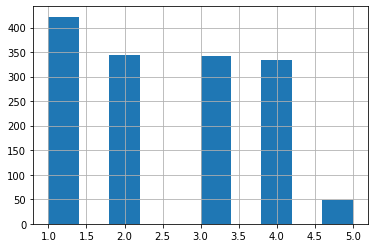

In [ ]:
df_proc['AnnualIncome_cat'].hist()

De este modo esta variable es mas estable antes fluctuaciones 

# Train-Test split estratificado

Dividimos entre Entrenamiento y Validación. teniendo en cuenta que ambos datasets tengan la misma proporcion de valores


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=497, random_state=420)
for train_index, test_index in split.split(df_proc, df_proc.AnnualIncome_cat):
    strat_train_set = df_proc.loc[train_index] 
    strat_test_set = df_proc.loc[test_index]

In [ ]:
strat_train_set.TravelInsurance.value_counts()/len(strat_train_set)

0    0.636455
1    0.363545
Name: TravelInsurance, dtype: float64

In [ ]:
print('Proporcion de bin AnnualIncome sobre el total en conjunto test')
strat_test_set.AnnualIncome_cat.value_counts() / len(strat_test_set)

Proporcion de bin AnnualIncome sobre el total en conjunto test


1    0.283702
2    0.231388
3    0.229376
4    0.223340
5    0.032193
Name: AnnualIncome_cat, dtype: float64

In [ ]:
print('Proporcion de bin AnnualIncome sobre el total en conjunto df')
df_proc.AnnualIncome_cat.value_counts() / len(df_proc)

Proporcion de bin AnnualIncome sobre el total en conjunto df


1    0.283221
2    0.231544
3    0.228859
4    0.223490
5    0.032886
Name: AnnualIncome_cat, dtype: float64

In [ ]:
del strat_train_set['AnnualIncome_cat']
del strat_test_set['AnnualIncome_cat']

In [ ]:
# mm = MinMaxScaler()
# strat_train_set_num = mm.fit_transform(strat_train_set[cont_names])
# strat_test_set_num = mm.transform(strat_test_set[cont_names])

# mm = StandardScaler()
# strat_train_set_num = mm.fit_transform(strat_train_set[cont_names])
# strat_test_set_num = mm.transform(strat_test_set[cont_names])

mm = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
strat_train_set_num = mm.fit_transform(strat_train_set[cont_names])
strat_test_set_num = mm.transform(strat_test_set[cont_names])

In [ ]:
strat_train_set.loc[:, cont_names] = strat_train_set_num
strat_test_set.loc[:, cont_names] = strat_test_set_num

In [ ]:
strat_train_set

,Age_25,Age_26,Age_27,Age_28,Age_29,Age_30,Age_31,Age_32,Age_33,Age_34,Age_35,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,FamilyMembers_2,FamilyMembers_3,FamilyMembers_4,FamilyMembers_5,FamilyMembers_6,FamilyMembers_7,FamilyMembers_8,FamilyMembers_9,ChronicDiseases_0,ChronicDiseases_1,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes,AnnualIncome,TravelInsurance
522,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0
431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
334,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1
473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1
1173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0,0
18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0
400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0


**Divido el set de datos en TRAIN Y TEST**

In [ ]:
X_train = strat_train_set.drop('TravelInsurance', axis=1)
y_train = strat_train_set.TravelInsurance

X_test = strat_test_set.drop('TravelInsurance', axis=1)
y_test = strat_test_set.TravelInsurance

# Oversampling SMOTE (data sintética)

El método SMOTE se basa en el sobremuestreo generando datos sintéticos, a partir de características comunes entre las muestras de la clase minoritaria.

El enfoque más utilizado para sintetizar nuevos ejemplos se denomina Técnica de sobremuestreo de minorías sintéticas, o **SMOTE** para abreviar. Esta técnica fue descrita por Nitesh Chawla, et al. en el paper de 2002: “SMOTE: Synthetic Minority Over-sampling Technique.”

Concretamente, el algoritmo se centrará sobre la clase minoritaria, en donde cada muestra de este subconjunto calculará sus K-vecinos más próximos. El número de vecinos K a tener en cuenta es un parámetro previamente dado al algoritmo (por defecto = 5), el cual define el número de vecinos a seleccionar.

Los k vecinos pertenecen también a esa clase minoritaria, y son aquellas muestras cuya distancia euclidiana a la muestra principal seleccionada es la menor. Posteriormente, se selecciona uno de los K vecinos de forma aleatoria y se replica generando muesrtas sintéticas entre la muestra principal seleccionadas y sus vecinos. Este proceso se repetirá hasta alcanzar un equilibrio entre ambas clases.

Esta generación sintética mejora lo ofrecido por otras técnicas básicas, aumentando el conjunto de datos. Sin embargo, también posee ciertas desventajas como la sobregeneración y el valor de la varianza obtenido que provoca solapamiento entre clases.

Fuente: https://oa.upm.es/52075/1/TFG_ADRIAN_GALINDO_HUERTA.pdf

In [ ]:
from imblearn.over_sampling import SMOTE 

balanced = SMOTE()
balanced_data_X,balanced_data_y=balanced.fit_sample(X_train, y_train)
balanced_data_X = pd.DataFrame(data=balanced_data_X,columns=X_train.columns )
balanced_data_y= pd.DataFrame(data=balanced_data_y,columns=['TravelInsurance'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## 1. Modelo Random Forest con RandomizedSearchCV -> 0.80 en Kaggle
Tercer submission, nos quedamos con esta. Utilizamos RandomizedSearchCV que mejoró mucho la performance. Y las clases fueron balanceadas con SMOTE. 

*Breve descripción del modelo Random Forest*


Los métodos de ensemble combinan múltiples modelos en uno nuevo con el objetivo de lograr un equilibro entre bias y varianza, consiguiendo así mejores predicciones que cualquiera de los modelos individuales originales.

Un modelo Random Forest está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping. Esto implica que cada árbol se entrena con unos datos ligeramente distintos. En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Fuente: https://www.cienciadedatos.net/documentos/py08_random_forest_python.html


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
            'n_estimators': [50, 70, 100, 150], #subí la cantidad de estimadores, hace todo más lento pero tiene mejor perfo
            'criterion': ['gini', 'entropy'],
            'max_depth': [6, 9 , 12, 13, None], #máxima profundidad sumé la opción None por si podía clasificar sin profundidad y algunos valores mas bajos también
            'min_samples_leaf': [2, 3], #minimo numero de nodos en un punto
            'min_samples_split' : [3, 4], #minimo numero de muestras para partir un nodo interno
            'max_features' : [0.5, 'log2'] #numero maximo de features permitido en un arbol individual
            }
            

model = RandomForestClassifier(n_jobs=-1, oob_score=True, )
gs_rf = RandomizedSearchCV(model, param_grid, scoring='f1', cv=4, refit=True)

gs_rf.fit(balanced_data_X, balanced_data_y.values.ravel())

results = gs_rf.cv_results_

In [ ]:
df = pd.DataFrame(results)
df[['param_n_estimators','param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 
     'param_max_features', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_test_score,rank_test_score
1,150,entropy,None,2,3,log2,0.773203,1
8,50,gini,13,3,4,0.5,0.765239,2
6,150,entropy,12,2,3,0.5,0.764565,3
7,150,gini,None,3,4,log2,0.763295,4
2,70,gini,None,2,3,0.5,0.762177,5


**Reporte de clasificación**

In [ ]:
predictions = gs_rf.predict(X_test)
print(f'OOB score { gs_rf.best_estimator_.oob_score_}')
print(classification_report(y_test, predictions))

OOB score 0.8188291139240507
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       326
           1       0.76      0.61      0.68       171

    accuracy                           0.80       497
   macro avg       0.79      0.75      0.76       497
weighted avg       0.80      0.80      0.79       497



**Importancia de los FEATURES en estudio**

In [ ]:
pd.Series(index=X_train.columns, data=gs_rf.best_estimator_.feature_importances_).sort_values(ascending=False)

AnnualIncome                                    0.222769
EverTravelledAbroad_Yes                         0.092389
EverTravelledAbroad_No                          0.084506
Age_28                                          0.037891
FamilyMembers_7                                 0.037396
FamilyMembers_6                                 0.036670
Age_33                                          0.036093
FamilyMembers_4                                 0.034934
FamilyMembers_5                                 0.034616
Age_34                                          0.034309
FrequentFlyer_Yes                               0.031147
ChronicDiseases_0                               0.030205
ChronicDiseases_1                               0.029716
FrequentFlyer_No                                0.028530
FamilyMembers_3                                 0.028499
Employment Type_Government Sector               0.026681
Age_31                                          0.022699
Employment Type_Private Sector/

## 2. Modelo GradientBoosting con SMOTE y GridSearchCV -> 0.782 en Kaggle
Segundo intento, cambiando RandomForest por GradientBoosting, con misma técnica de balanceo y de validación cruzada (en grilla)

*Breve descripción de Gradient Boosting*

Un modelo Gradient Boosting está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial, de forma que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Muchos métodos predictivos generan modelos globales en los que una única ecuación se aplica a todo el espacio muestral. Cuando el caso de uso implica múltiples predictores, que interaccionan entre ellos de forma compleja y no lineal, es muy difícil encontrar un único modelo global que sea capaz de reflejar la relación entre las variables. Los métodos estadísticos y de machine learning basados en árboles engloban a un conjunto de técnicas supervisadas no paramétricas que consiguen segmentar el espacio de los predictores en regiones simples, dentro de las cuales es más sencillo manejar las interacciones. Es esta característica la que les proporciona gran parte de su potencial.

Fuente: https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python.html 



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
            'loss': ['deviance'],
            'learning_rate': [0.1, 0.2],
            'n_estimators' : [110, 120],
            'subsample' : [1.],
            'criterion' : ['friedman_mse', 'mae'],
            'min_samples_split' : [2, 3, 4],
            'min_samples_leaf': [2], 
            'max_depth' : [3],
            'max_features' : [0.5]
            }

model = GradientBoostingClassifier(random_state=420)
gs_gb = GridSearchCV(model, param_grid, scoring='f1', cv=4, refit=True)
gs_gb.fit(balanced_data_X, balanced_data_y.values.ravel());

In [ ]:
df = pd.DataFrame(gs_gb.cv_results_)
df[['param_criterion', 'param_learning_rate', 'param_loss', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'param_subsample', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,mean_test_score,rank_test_score
10,friedman_mse,0.2,deviance,3,0.5,2,4,110,1,0.786615,1
6,friedman_mse,0.2,deviance,3,0.5,2,2,110,1,0.786615,1
8,friedman_mse,0.2,deviance,3,0.5,2,3,110,1,0.786615,1
11,friedman_mse,0.2,deviance,3,0.5,2,4,120,1,0.785071,4
9,friedman_mse,0.2,deviance,3,0.5,2,3,120,1,0.785071,4


**Reporte de clasificación**

In [ ]:
predictions = gs_gb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       326
           1       0.77      0.65      0.70       171

    accuracy                           0.81       497
   macro avg       0.80      0.77      0.78       497
weighted avg       0.81      0.81      0.81       497



**Importancia de las FEATURES en estudio**

In [ ]:
pd.Series(index=X_train.columns, data=gs_gb.best_estimator_.feature_importances_).sort_values(ascending=False)

AnnualIncome                                    0.332116
EverTravelledAbroad_No                          0.155221
FamilyMembers_7                                 0.052253
FamilyMembers_6                                 0.047169
Age_34                                          0.041291
Age_33                                          0.038829
FrequentFlyer_Yes                               0.035327
Age_28                                          0.029926
FamilyMembers_5                                 0.027607
EverTravelledAbroad_Yes                         0.026098
Age_31                                          0.020562
FamilyMembers_2                                 0.017026
ChronicDiseases_0                               0.017022
FamilyMembers_4                                 0.014621
ChronicDiseases_1                               0.014431
FamilyMembers_3                                 0.014372
Employment Type_Government Sector               0.013764
Age_30                         

## 3. Modelo Random Forest con GridSearchCV -> 0.769 en Kaggle

Esta fue la primer submission por arriba del baseline. Mejoró cuando utilizamos SMOTE y las clases estaban más balanceadas.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
            'n_estimators': [50, 70, 100, 150], #subí la cantidad de estimadores, hace todo más lento pero tiene mejor perfo
            'criterion': ['gini', 'entropy'],
            'max_depth': [6, 9 , 12, 13, None], #máxima profundidad sumé la opción None por si podía clasificar sin profundidad y algunos valores mas bajos también
            'min_samples_leaf': [2, 3], #minimo numero de nodos en un punto
            'min_samples_split' : [3, 4], #minimo numero de muestras para partir un nodo interno
            'max_features' : [0.5, 'log2'] #numero maximo de features permitido en un arbol individual
            }
            

model = RandomForestClassifier(n_jobs=-1, oob_score=True, )
gs_rf = RandomizedSearchCV(model, param_grid, scoring='f1', cv=4, refit=True)

gs_rf.fit(balanced_data_X, balanced_data_y.values.ravel())

results = gs_rf.cv_results_

In [ ]:
df = pd.DataFrame(results)
df[['param_n_estimators','param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 
     'param_max_features', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_test_score,rank_test_score
3,100,entropy,None,2,3,0.5,0.778899,1
8,50,entropy,None,2,4,log2,0.775397,2
9,50,gini,None,2,4,log2,0.760842,3
5,50,gini,13,3,3,0.5,0.760429,4
2,50,entropy,9,3,4,0.5,0.752372,5


**Reporte de clasificación**

In [ ]:
predictions = gs_rf.predict(X_test)
print(f'OOB score { gs_rf.best_estimator_.oob_score_}')
print(classification_report(y_test, predictions))

OOB score 0.8117088607594937
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       326
           1       0.76      0.64      0.70       171

    accuracy                           0.81       497
   macro avg       0.80      0.77      0.78       497
weighted avg       0.81      0.81      0.80       497



In [ ]:
pd.Series(index=X_train.columns, data=gs_rf.best_estimator_.feature_importances_).sort_values(ascending=False)

AnnualIncome                                    0.245037
EverTravelledAbroad_Yes                         0.088127
EverTravelledAbroad_No                          0.055312
FamilyMembers_6                                 0.043063
FamilyMembers_7                                 0.042629
Age_34                                          0.041897
FamilyMembers_4                                 0.037598
Age_33                                          0.035863
FamilyMembers_5                                 0.034161
Age_28                                          0.032283
ChronicDiseases_1                               0.031084
ChronicDiseases_0                               0.029885
FrequentFlyer_No                                0.028064
FamilyMembers_3                                 0.025807
FrequentFlyer_Yes                               0.024409
Age_31                                          0.022798
Employment Type_Private Sector/Self Employed    0.022257
Employment Type_Government Sect

# Submission

In [ ]:
test = pd.read_csv("https://raw.githubusercontent.com/data-datum/04.aprendizaje-supervisado/main/travel_insurance_prediction_test.csv")
test_id = test["Customer"]
test.drop('Customer', inplace=True,axis=1)

In [ ]:
test.shape

(497, 8)

In [ ]:
test_cat = oh.transform(test[cat_names])

In [ ]:
test_num = mm.transform(test[cont_names])

In [ ]:
test_sub = np.concatenate([test_cat, test_num], axis=1)

In [ ]:
best_predict = gs_cb.predict(test_sub)

In [ ]:
submission = pd.DataFrame(list(zip(test_id, best_predict)), columns=["Customer", "TravelInsurance"])
submission.to_csv("travel_insurance_submission.csv", header=True, index=False)

In [ ]:
submission.sum()

--------------------------------------------------------------------------------
<center>
<h3>Conclusión<h3>

</center>



* En esta notebook se encuentran 3 modelos de Aprendizaje supervisado con los cuale se submitieron los valores de predicción que superaron en el baseline proporcionado por el profesor Cardellino que constaba de un árbol de decisión. 

*Los modelos son*:

* Random Forest con RandomizedSearchCV (0.80 en Kaggle)
* Gradient Boosting con GridSearchCV (0.782 en Kaggle)
* Random Forest con GridSearchCV (0.769 en Kaggle)

De los tres modelos mencionados, se logró un F1-score más alto (de 0.80) con Random Forest RandomizedSearchCV.


La principal diferencia entre Random Forest y Gradient Boosting es el modo en que se construyen los arboles y en como se combinan los resultados para la salida del modelo.
En los random forest los arboles se constuyen independientemente y el resultado final es el promedio de los resultados. En gradient boosting se arman los arboles de a uno a la vez y el resultado se va combinando a lo largo del proceso.

En general, los random forest funcionan bien para la detección de objetos de varias clases, mientras que Gradient Boosting funciona bien cuando tiene datos desequilibrados.